In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from sklearn.linear_model import LinearRegression

from pandas.plotting import register_matplotlib_converters
from pylab import rcParams
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'
register_matplotlib_converters()
sns.set(style='whitegrid',palette='muted',font_scale=1.5)
rcParams['figure.figsize']=22,10

tf.random.set_seed(42)

from stldecompose import decompose

C:\Users\mert_\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data=pd.read_excel("DatabyDay-it-all-8years.xlsx")#data=pd.read_excel('Data2013-2018.xlsx',parse_dates=['Date'],index_col='Date')

In [3]:
data.head()

,Date,Truck
0,2011-01-01,0.0
1,2011-01-02,0.0
2,2011-01-03,0.0
3,2011-01-04,0.0
4,2011-01-05,1.0


In [4]:
data.index=data['Date']
data.drop(columns='Date',inplace=True)

In [5]:
data=data.resample('W').sum()
data.head()

,Truck
Date,
2011-01-02,0.0
2011-01-09,25.0
2011-01-16,19.0
2011-01-23,23.0
2011-01-30,25.0


In [6]:
data=data.loc['2013-1-1':,:]
data.head()

,Truck
Date,
2013-01-06,27.0
2013-01-13,24.0
2013-01-20,20.0
2013-01-27,18.0
2013-02-03,15.0


In [7]:
#data.index=pd.to_datetime(data.index)

In [8]:
data['week']=data.index.week
data['month']=data.index.month
data['quarter']=data.index.quarter

<ipython-input-8-3af9b3e3f6f9>:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data['week']=data.index.week


In [9]:
#decopm=decompose(data.Truck)

In [10]:
#data['seasonal']=decopm.seasonal
#data['trend']=decopm.trend

<AxesSubplot:xlabel='Date', ylabel='Truck'>

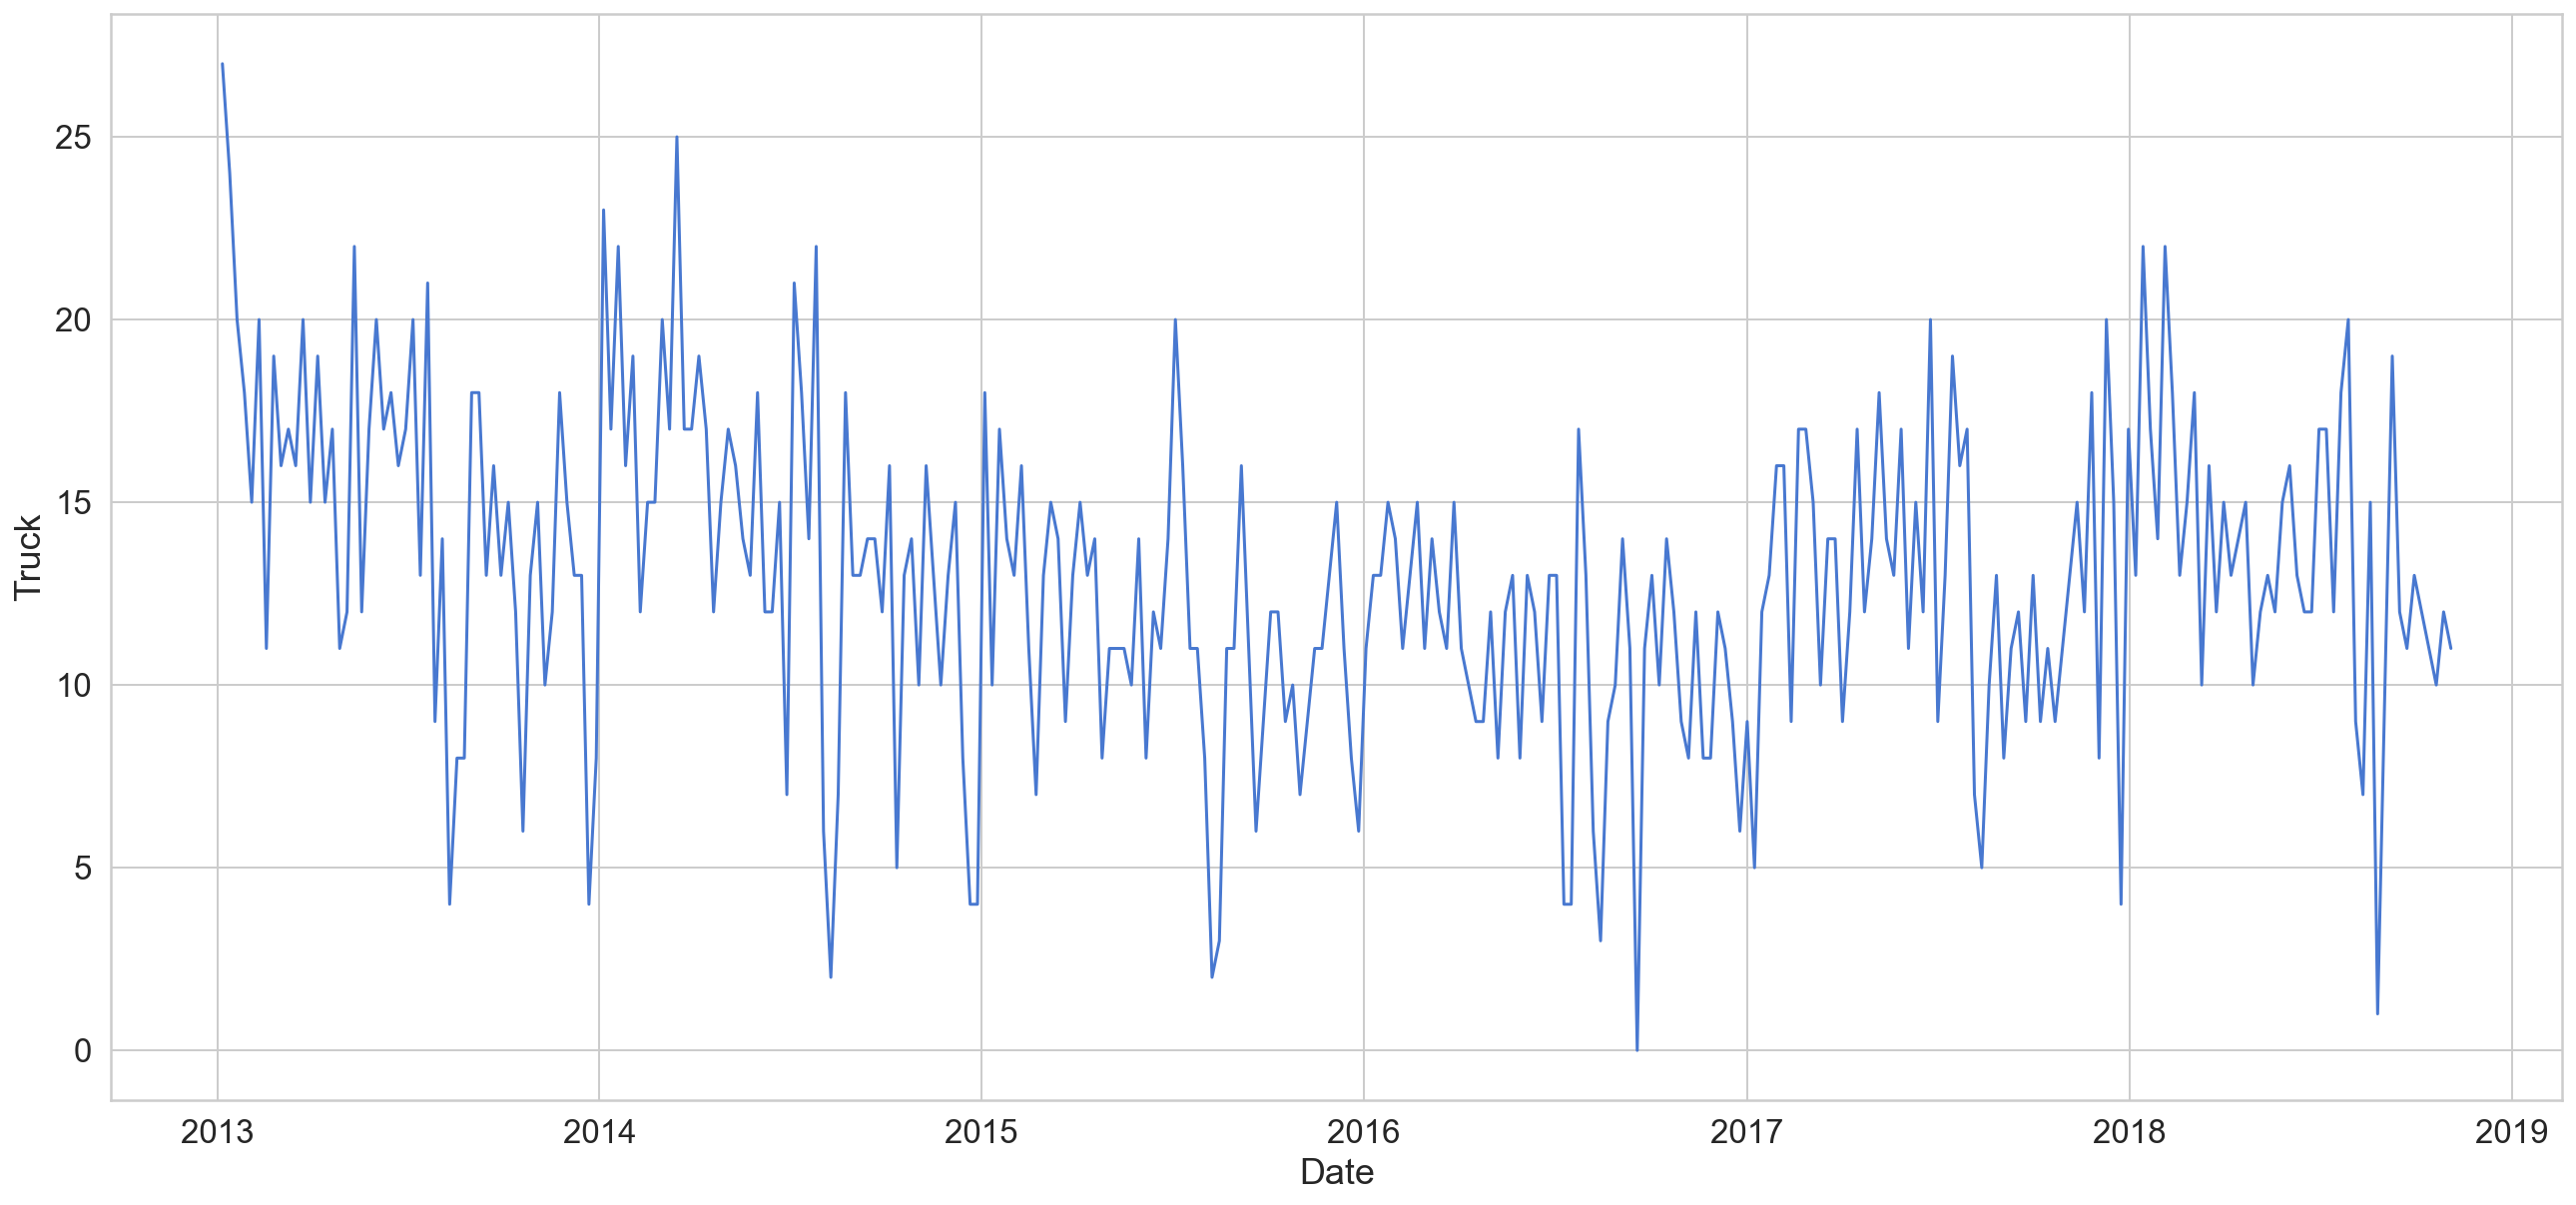

In [11]:
sns.lineplot(x=data.index,y='Truck',data=data)

<AxesSubplot:xlabel='Date', ylabel='Truck'>

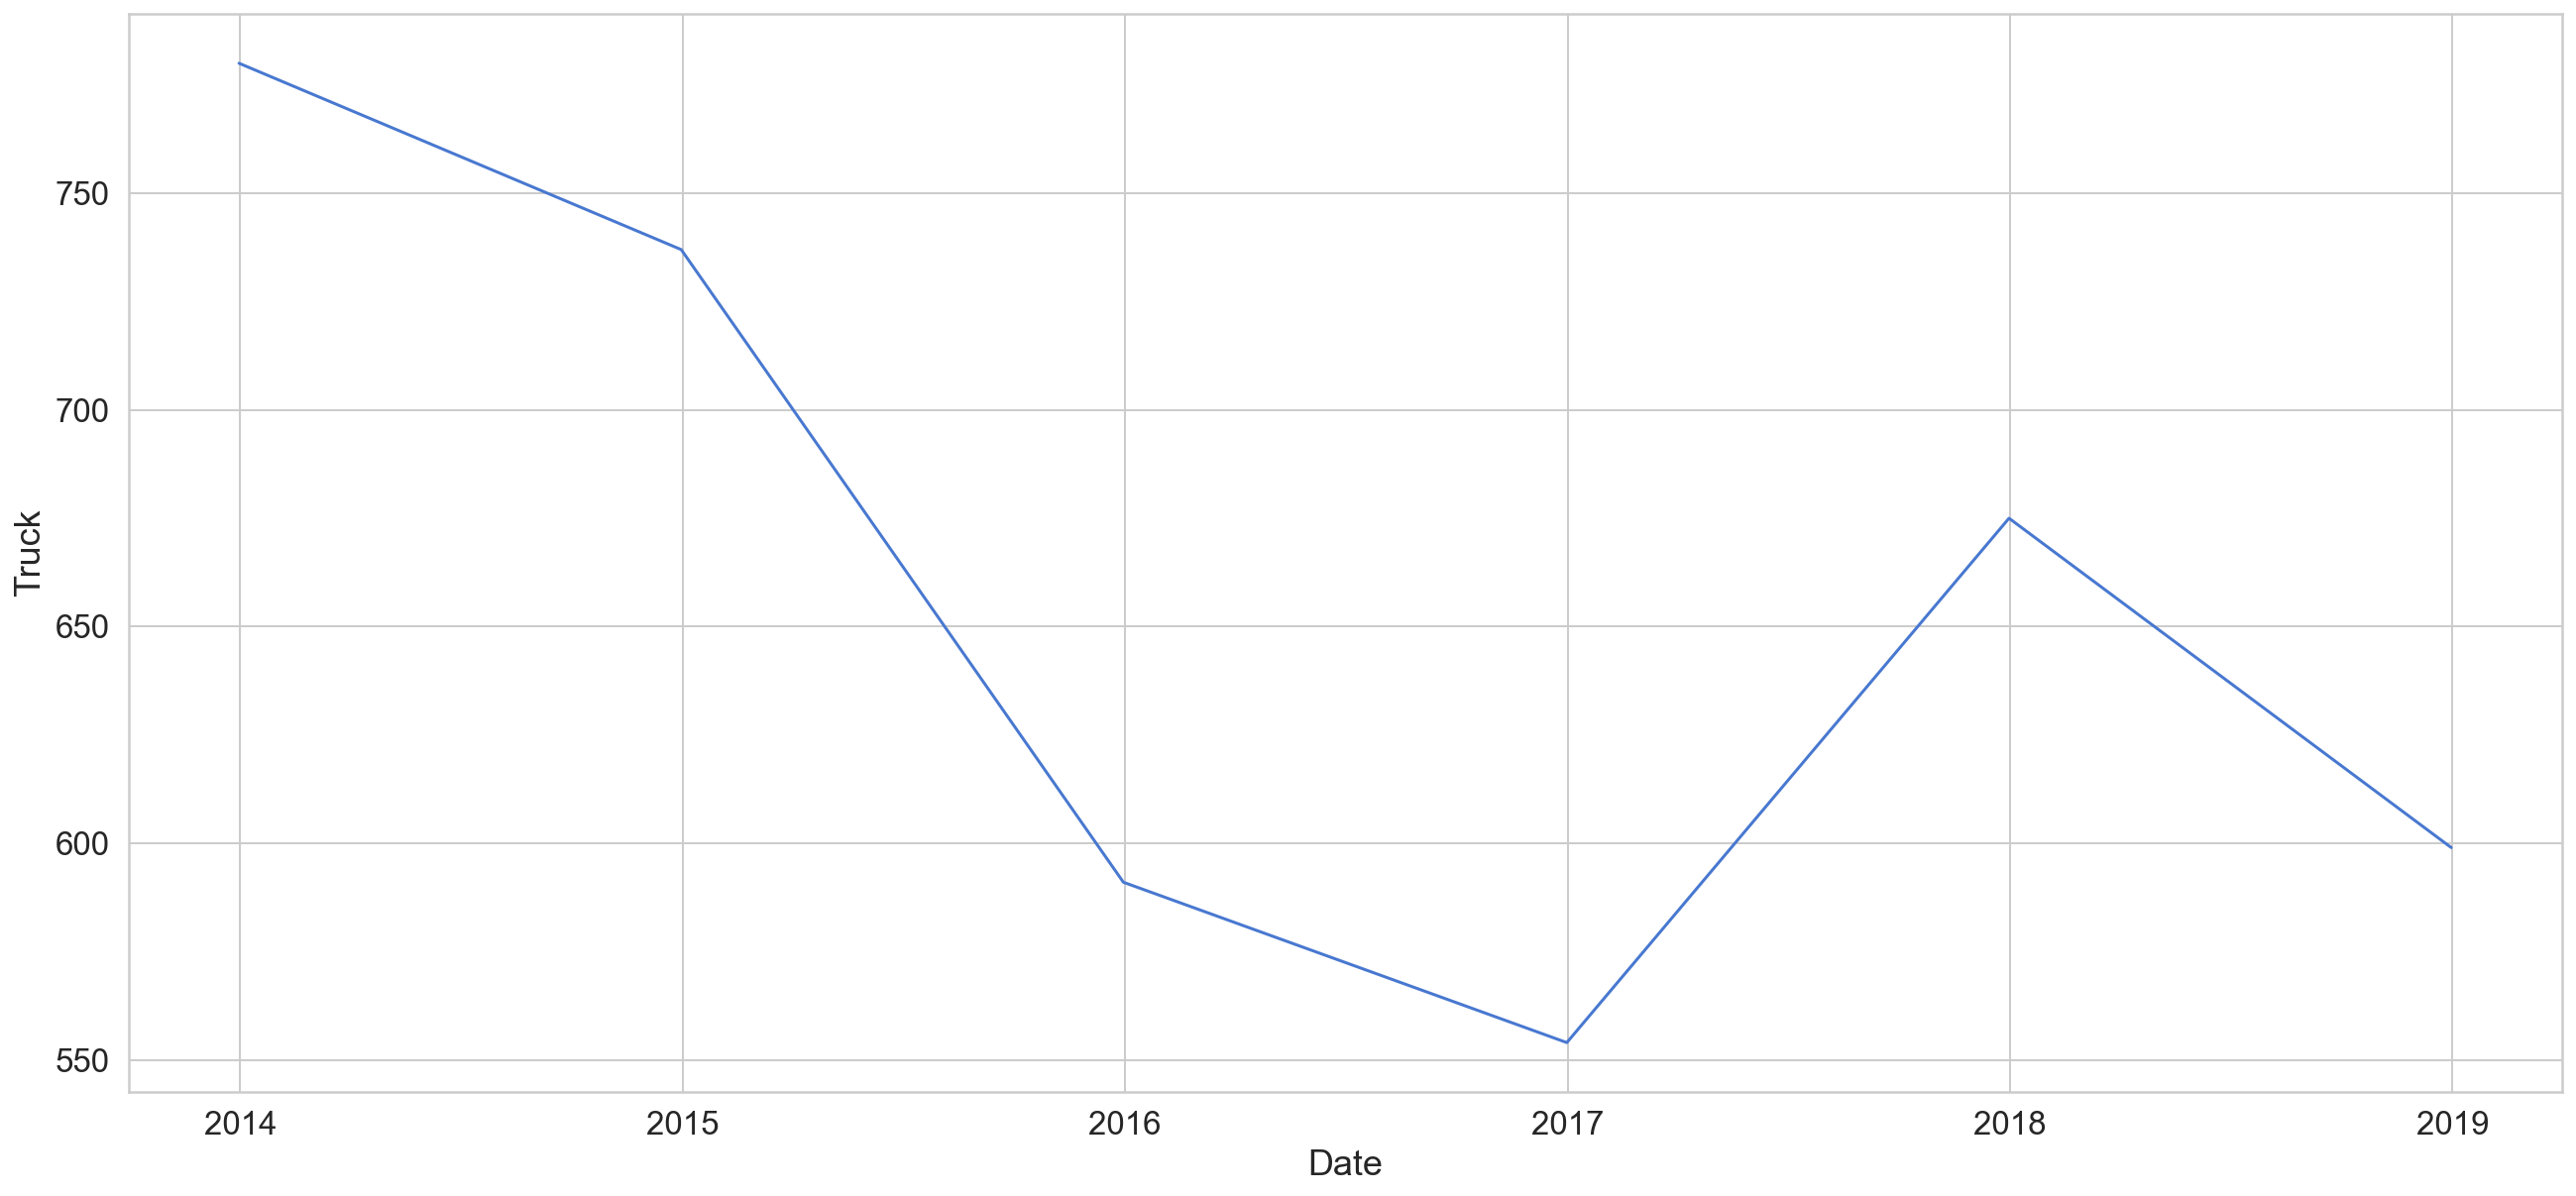

In [12]:
data_by_year=data.resample('Y').sum()
sns.lineplot(x=data_by_year.index,y='Truck',data=data_by_year)

<AxesSubplot:xlabel='month', ylabel='Truck'>

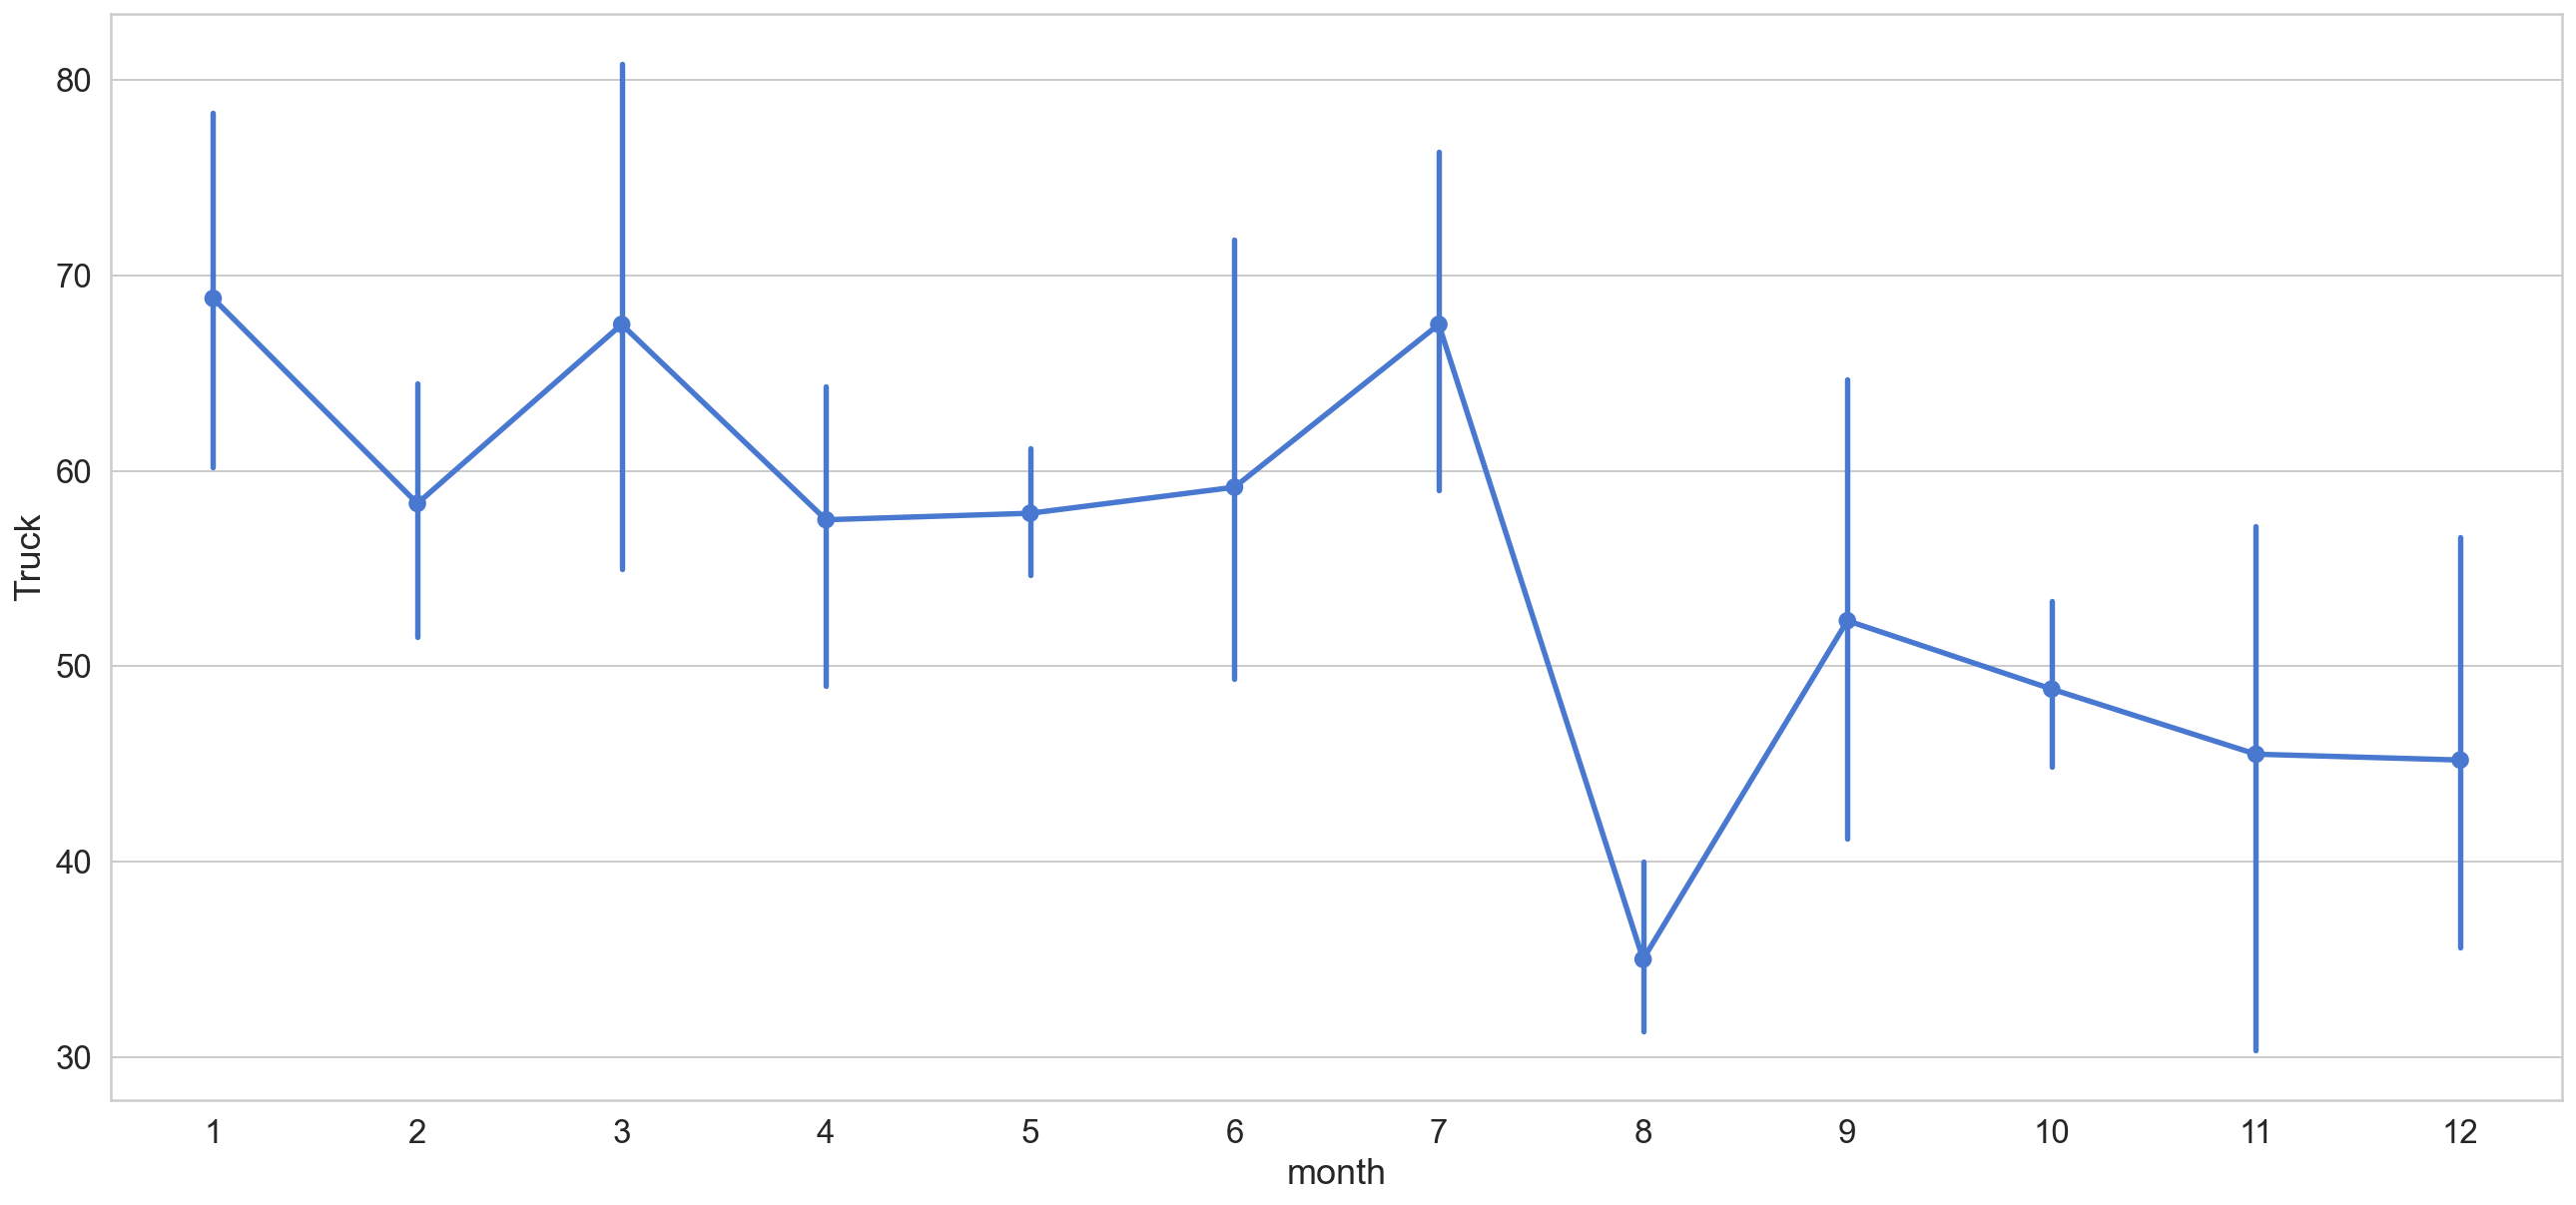

In [13]:
data_by_month=data.resample('M').sum()
data_by_month['month']=data_by_month.index.month
sns.pointplot(data=data_by_month,x='month',y='Truck')

In [14]:
data_by_month

,Truck,week,month,quarter
Date,,,,
2013-01-31,89.0,10,1,4
2013-02-28,65.0,26,2,4
2013-03-31,84.0,55,3,5
2013-04-30,62.0,62,4,8
2013-05-31,63.0,78,5,8
...,...,...,...,...
2018-07-31,84.0,140,7,15
2018-08-31,32.0,130,8,12
2018-09-30,65.0,185,9,15


<AxesSubplot:xlabel='week', ylabel='Truck'>

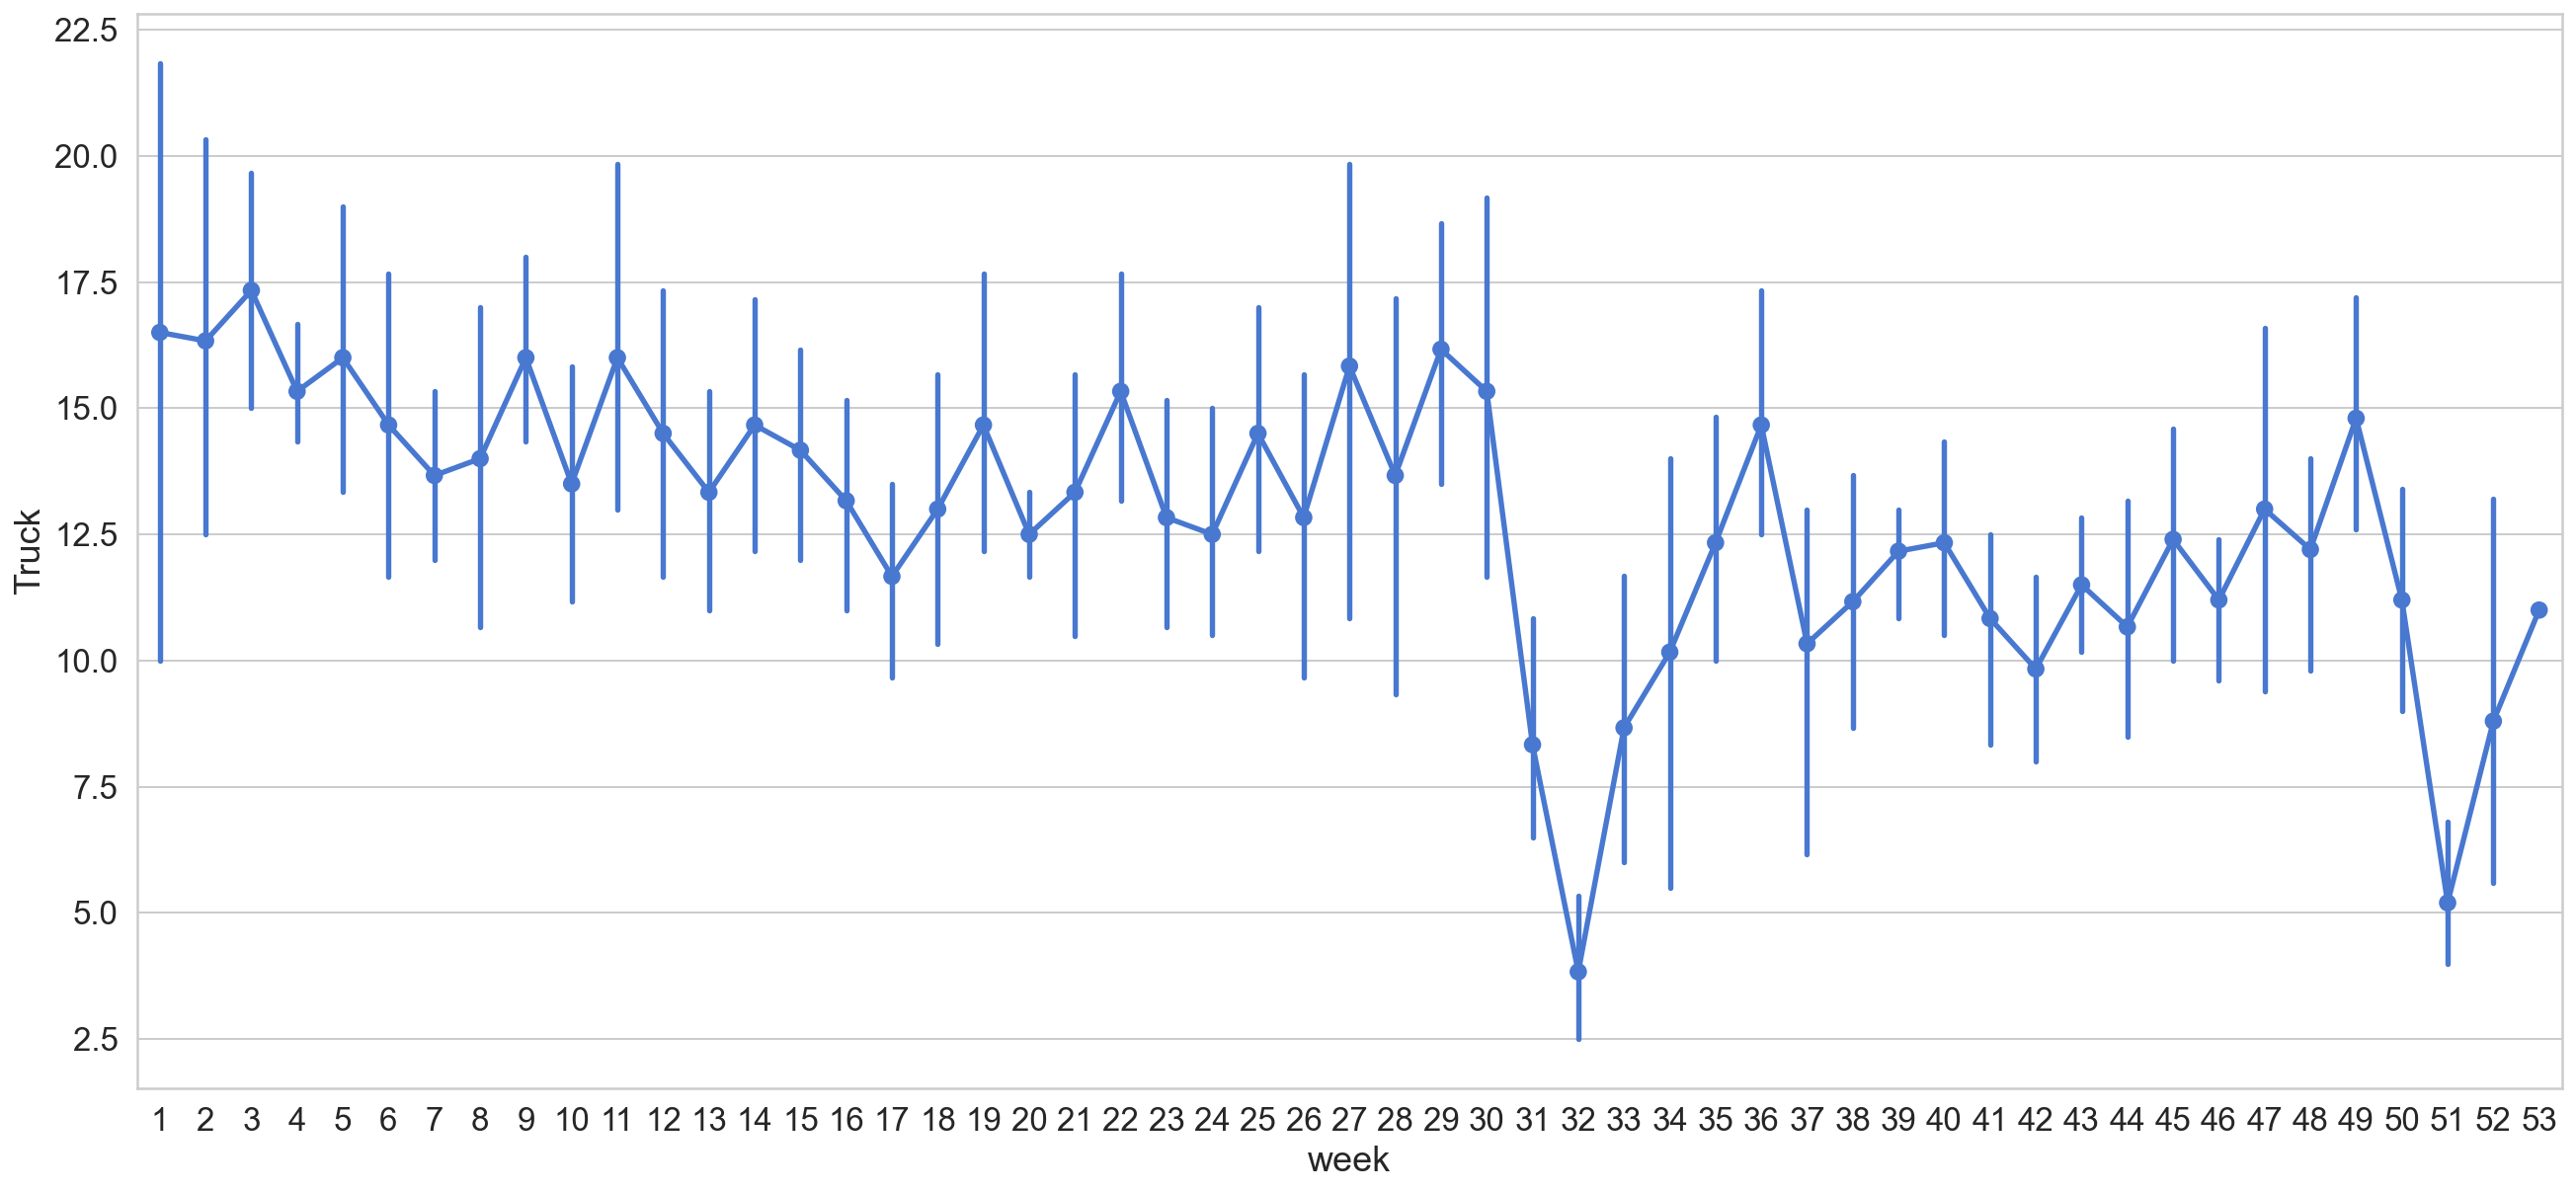

In [15]:
sns.pointplot(data=data,x='week',y='Truck')

In [16]:
scalerx = StandardScaler()
scalery = StandardScaler()

In [18]:
scalerx.fit(data.iloc[:,1:])
data.iloc[:,1:]=scalerx.transform(data.iloc[:,1:])

In [19]:
scalery.fit(data.iloc[:,0].values.reshape(-1,1))
data.iloc[:,0]= scalery.transform(data.iloc[:,0].values.reshape(-1,1))

In [20]:
data

,Truck,week,month,quarter
Date,,,,
2013-01-06,3.243375,-1.687509,-1.593818,-1.332961
2013-01-13,2.553054,-1.620035,-1.593818,-1.332961
2013-01-20,1.632627,-1.552562,-1.593818,-1.332961
2013-01-27,1.172413,-1.485088,-1.593818,-1.332961
2013-02-03,0.482093,-1.417614,-1.298846,-1.332961
...,...,...,...,...
2018-10-07,-0.208228,0.943970,1.060933,1.383429
2018-10-14,-0.438335,1.011444,1.060933,1.383429
2018-10-21,-0.668442,1.078917,1.060933,1.383429


In [21]:
pd.DataFrame(data.corr()['Truck'])

,Truck
Truck,1.000000
week,-0.383304
month,-0.365926
quarter,-0.350654


In [22]:
split_time=int(len(data)*0.855)
y_train=data['Truck'][:split_time].values.reshape(-1,1)
y_test=data['Truck'][split_time:].values.reshape(-1,1)
x_train=data.iloc[:split_time,1:6].values
x_test=data.iloc[split_time:,1:6].values

In [23]:
y_train.shape,x_train.shape,y_test.shape,x_test.shape

((260, 1), (260, 3), (45, 1), (45, 3))

In [24]:
model=Sequential()
model.add(Dense(32,input_shape=(x_train.shape[1],)))
model.add(Dense(16,activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2))

In [25]:
history=model.fit(x_train,y_train,epochs=22,validation_data=(x_test,y_test),batch_size=26,shuffle=False)

Epoch 1/22
10/10 [==============================] - 0s 15ms/step - loss: 1.1943 - val_loss: 0.7803
Epoch 2/22
10/10 [==============================] - 0s 3ms/step - loss: 0.9814 - val_loss: 0.7000
Epoch 3/22
10/10 [==============================] - 0s 3ms/step - loss: 0.9075 - val_loss: 0.7263
Epoch 4/22
10/10 [==============================] - 0s 3ms/step - loss: 0.9094 - val_loss: 0.7165
Epoch 5/22
10/10 [==============================] - 0s 3ms/step - loss: 0.9066 - val_loss: 0.7104
Epoch 6/22
10/10 [==============================] - 0s 3ms/step - loss: 0.8994 - val_loss: 0.7104
Epoch 7/22
10/10 [==============================] - 0s 3ms/step - loss: 0.8977 - val_loss: 0.7144
Epoch 8/22
10/10 [==============================] - 0s 3ms/step - loss: 0.8984 - val_loss: 0.7127
Epoch 9/22
10/10 [==============================] - 0s 3ms/step - loss: 0.8970 - val_loss: 0.7135
Epoch 10/22
10/10 [==============================] - 0s 3ms/step - loss: 0.8957 - val_loss: 0.7106
Epoch 11/22
10/10 

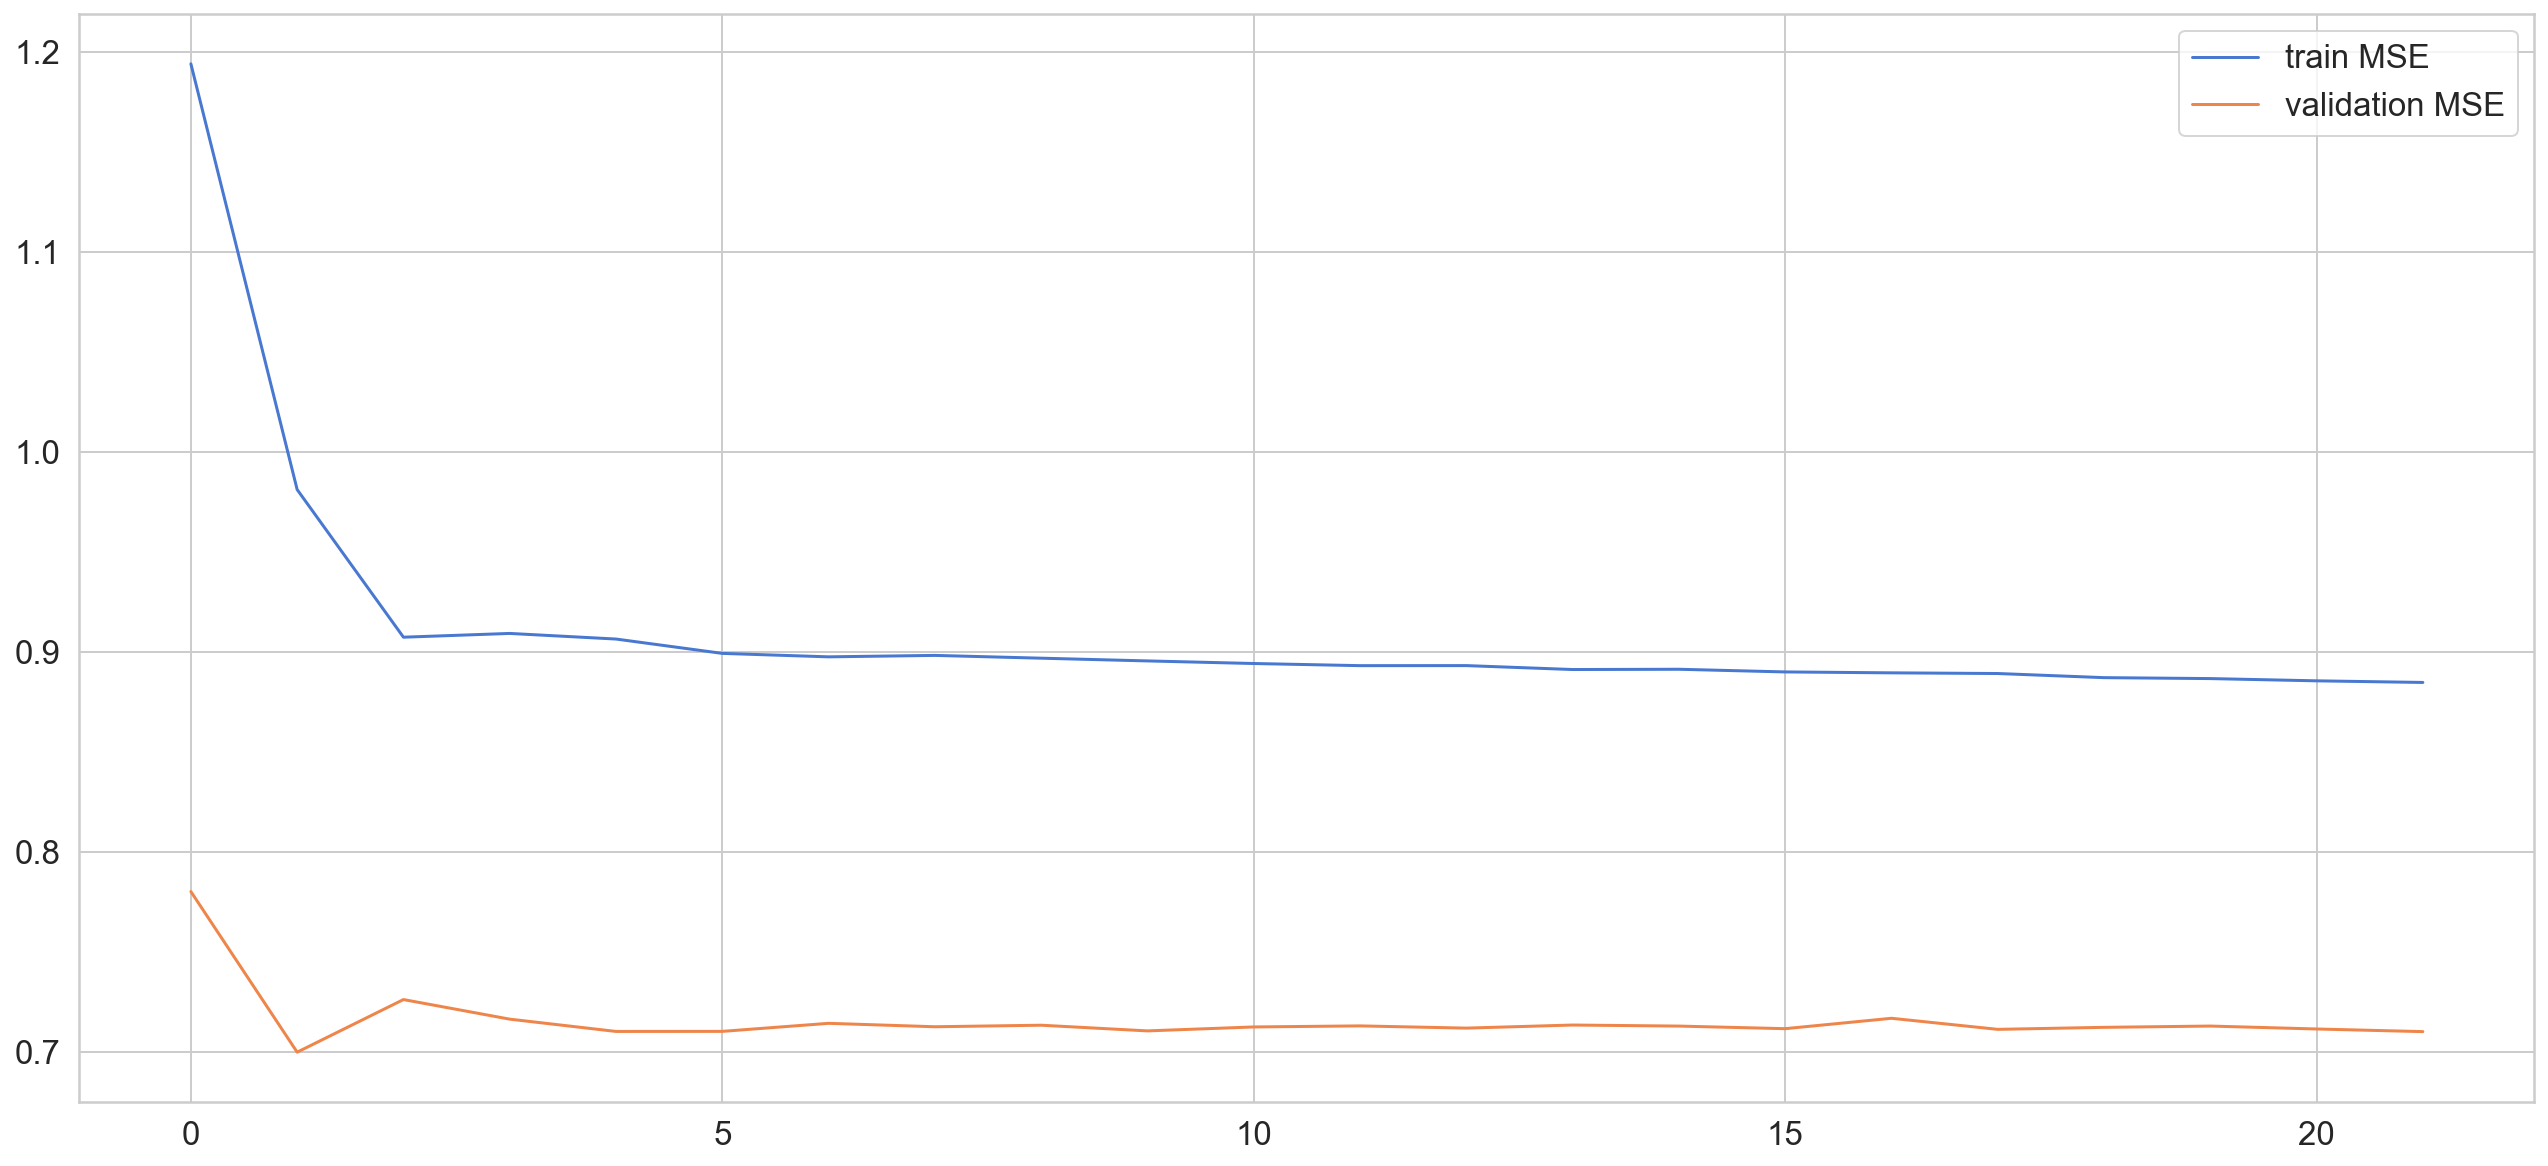

In [26]:
plt.plot(history.history['loss'],label='train MSE')
plt.plot(history.history['val_loss'],label='validation MSE')
plt.legend()

In [27]:
y_pred=model.predict(x_test)

In [28]:
y_train_inv=scalery.inverse_transform(y_train)
y_test_inv=scalery.inverse_transform(y_test)
y_pred_inv=scalery.inverse_transform(y_pred)

In [29]:
MAE=mean_absolute_error(y_test_inv,y_pred_inv)
RMSE=np.sqrt(mean_absolute_error(y_test_inv,y_pred_inv))

In [30]:
#r2_score(y_test_inv,y_pred_inv)

In [31]:
evaluate=pd.DataFrame([MAE,RMSE],columns=['Value'],index=['MAE','RMSE'])
evaluate

,Value
MAE,2.671728
RMSE,1.634542


In [33]:
#next_month1=np.array([[45.        ,  11.        ,  4.        ,  -0.22523679, -0.44587695]])
#yhat = model.predict(next_month1, verbose=0)
#yhat_inv=scalery.inverse_transform(yhat)
#yhat_inv

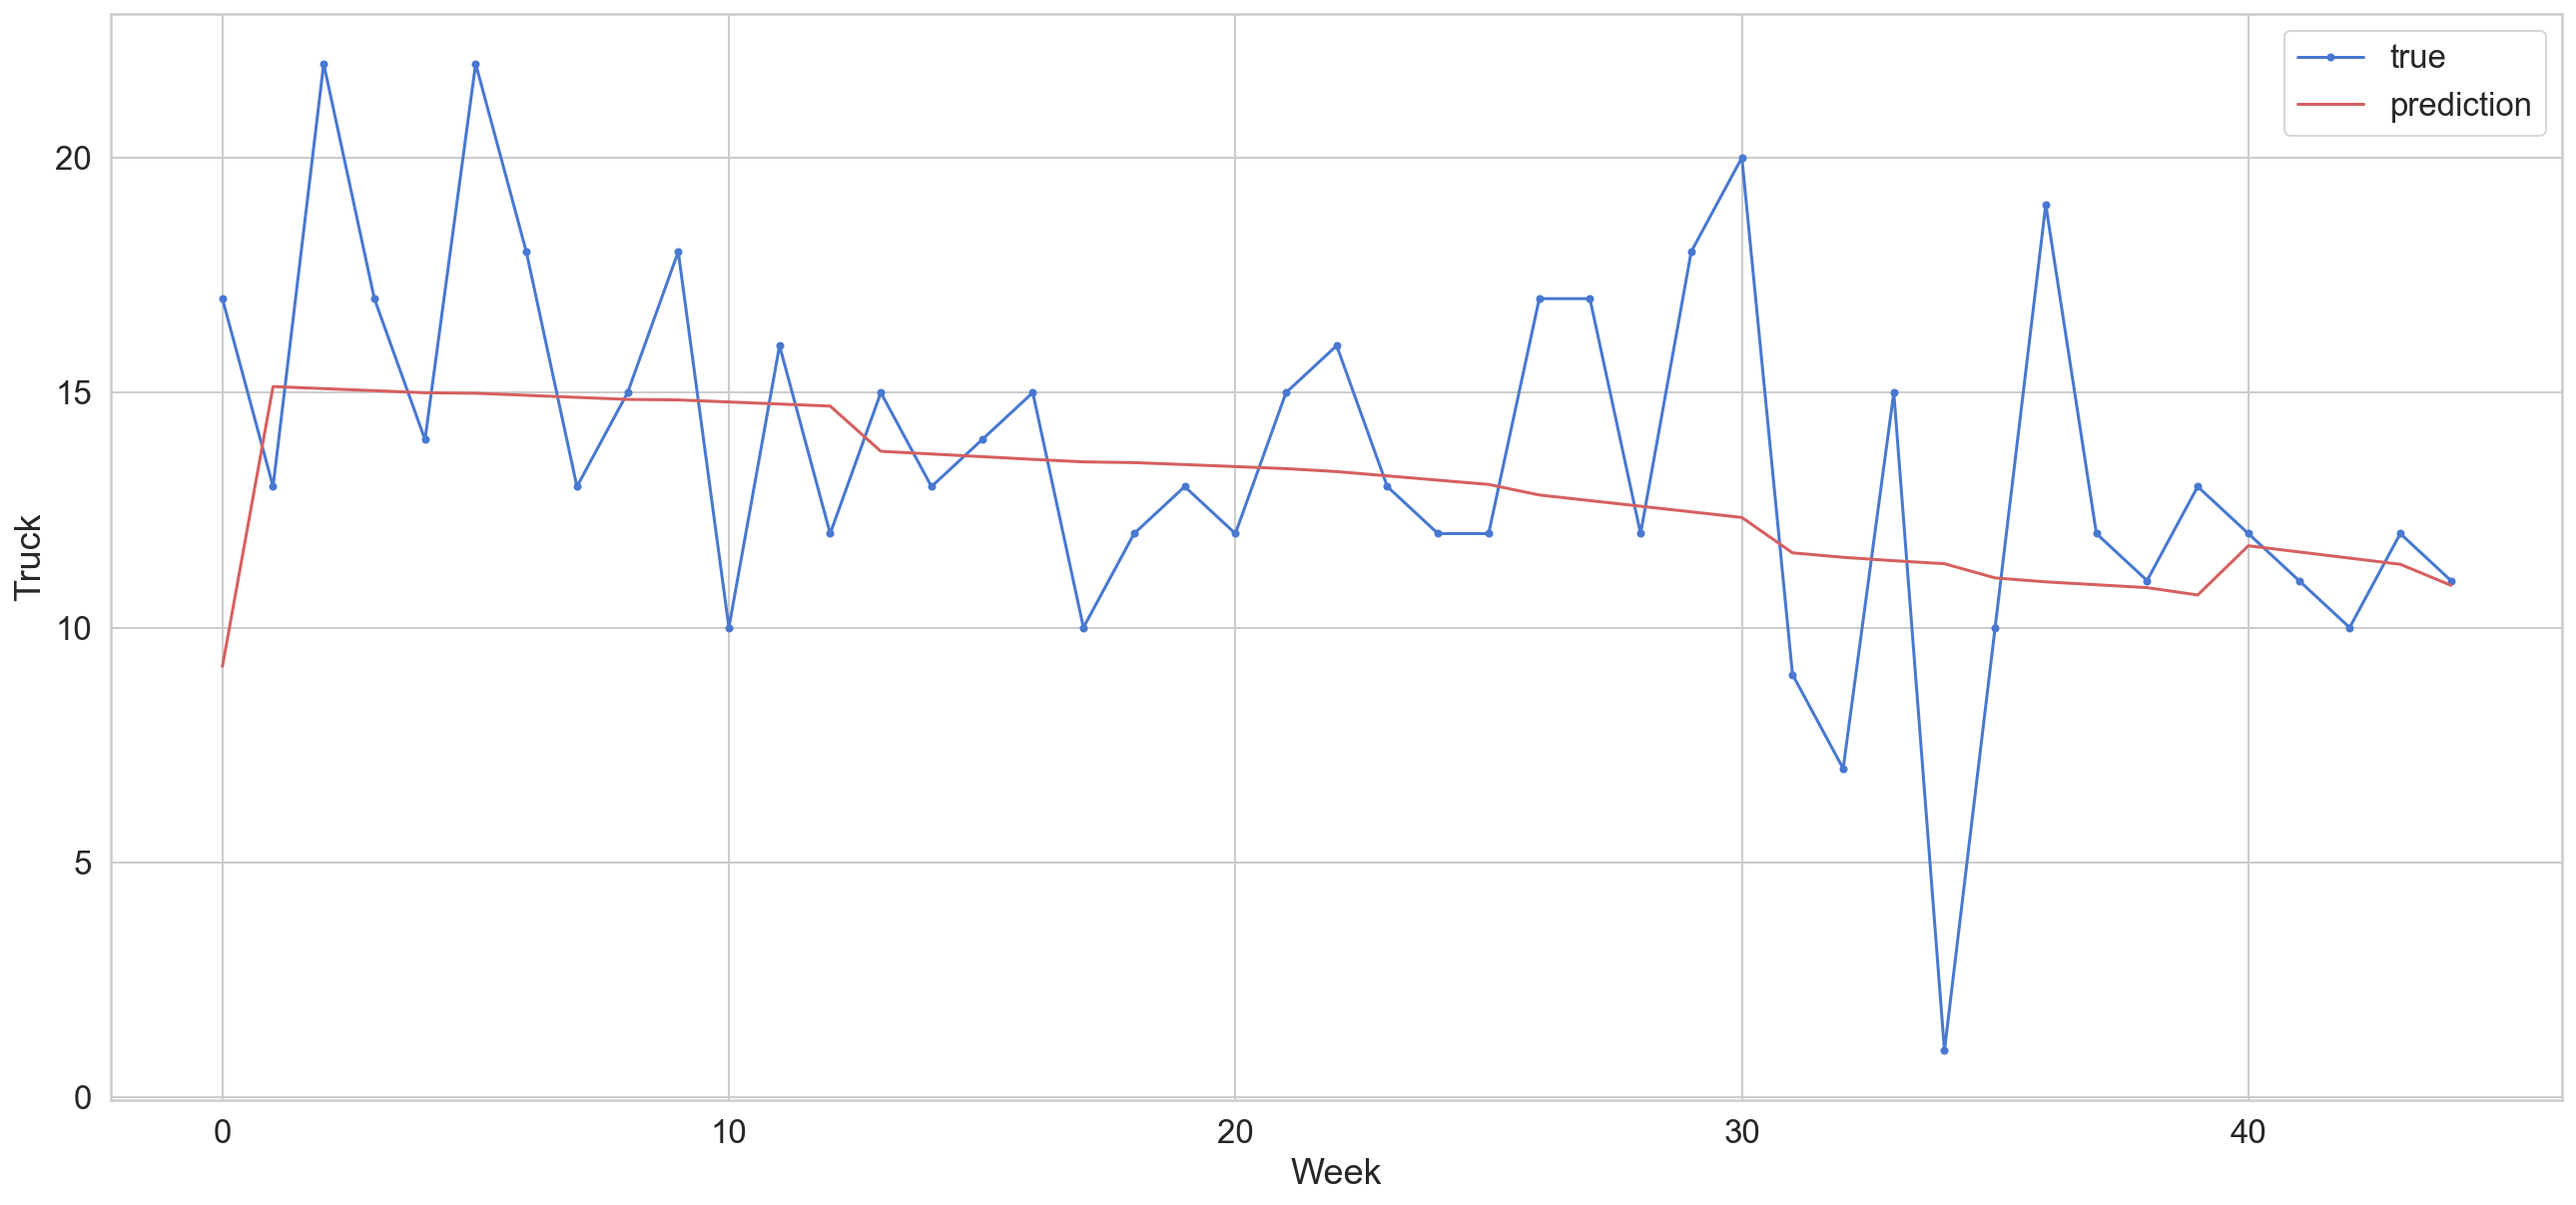

In [34]:
plt.plot(y_test_inv, marker='.', label="true")
plt.plot(y_pred_inv, 'r', label="prediction")
plt.ylabel('Truck')
plt.xlabel('Week')
plt.legend()
plt.show();

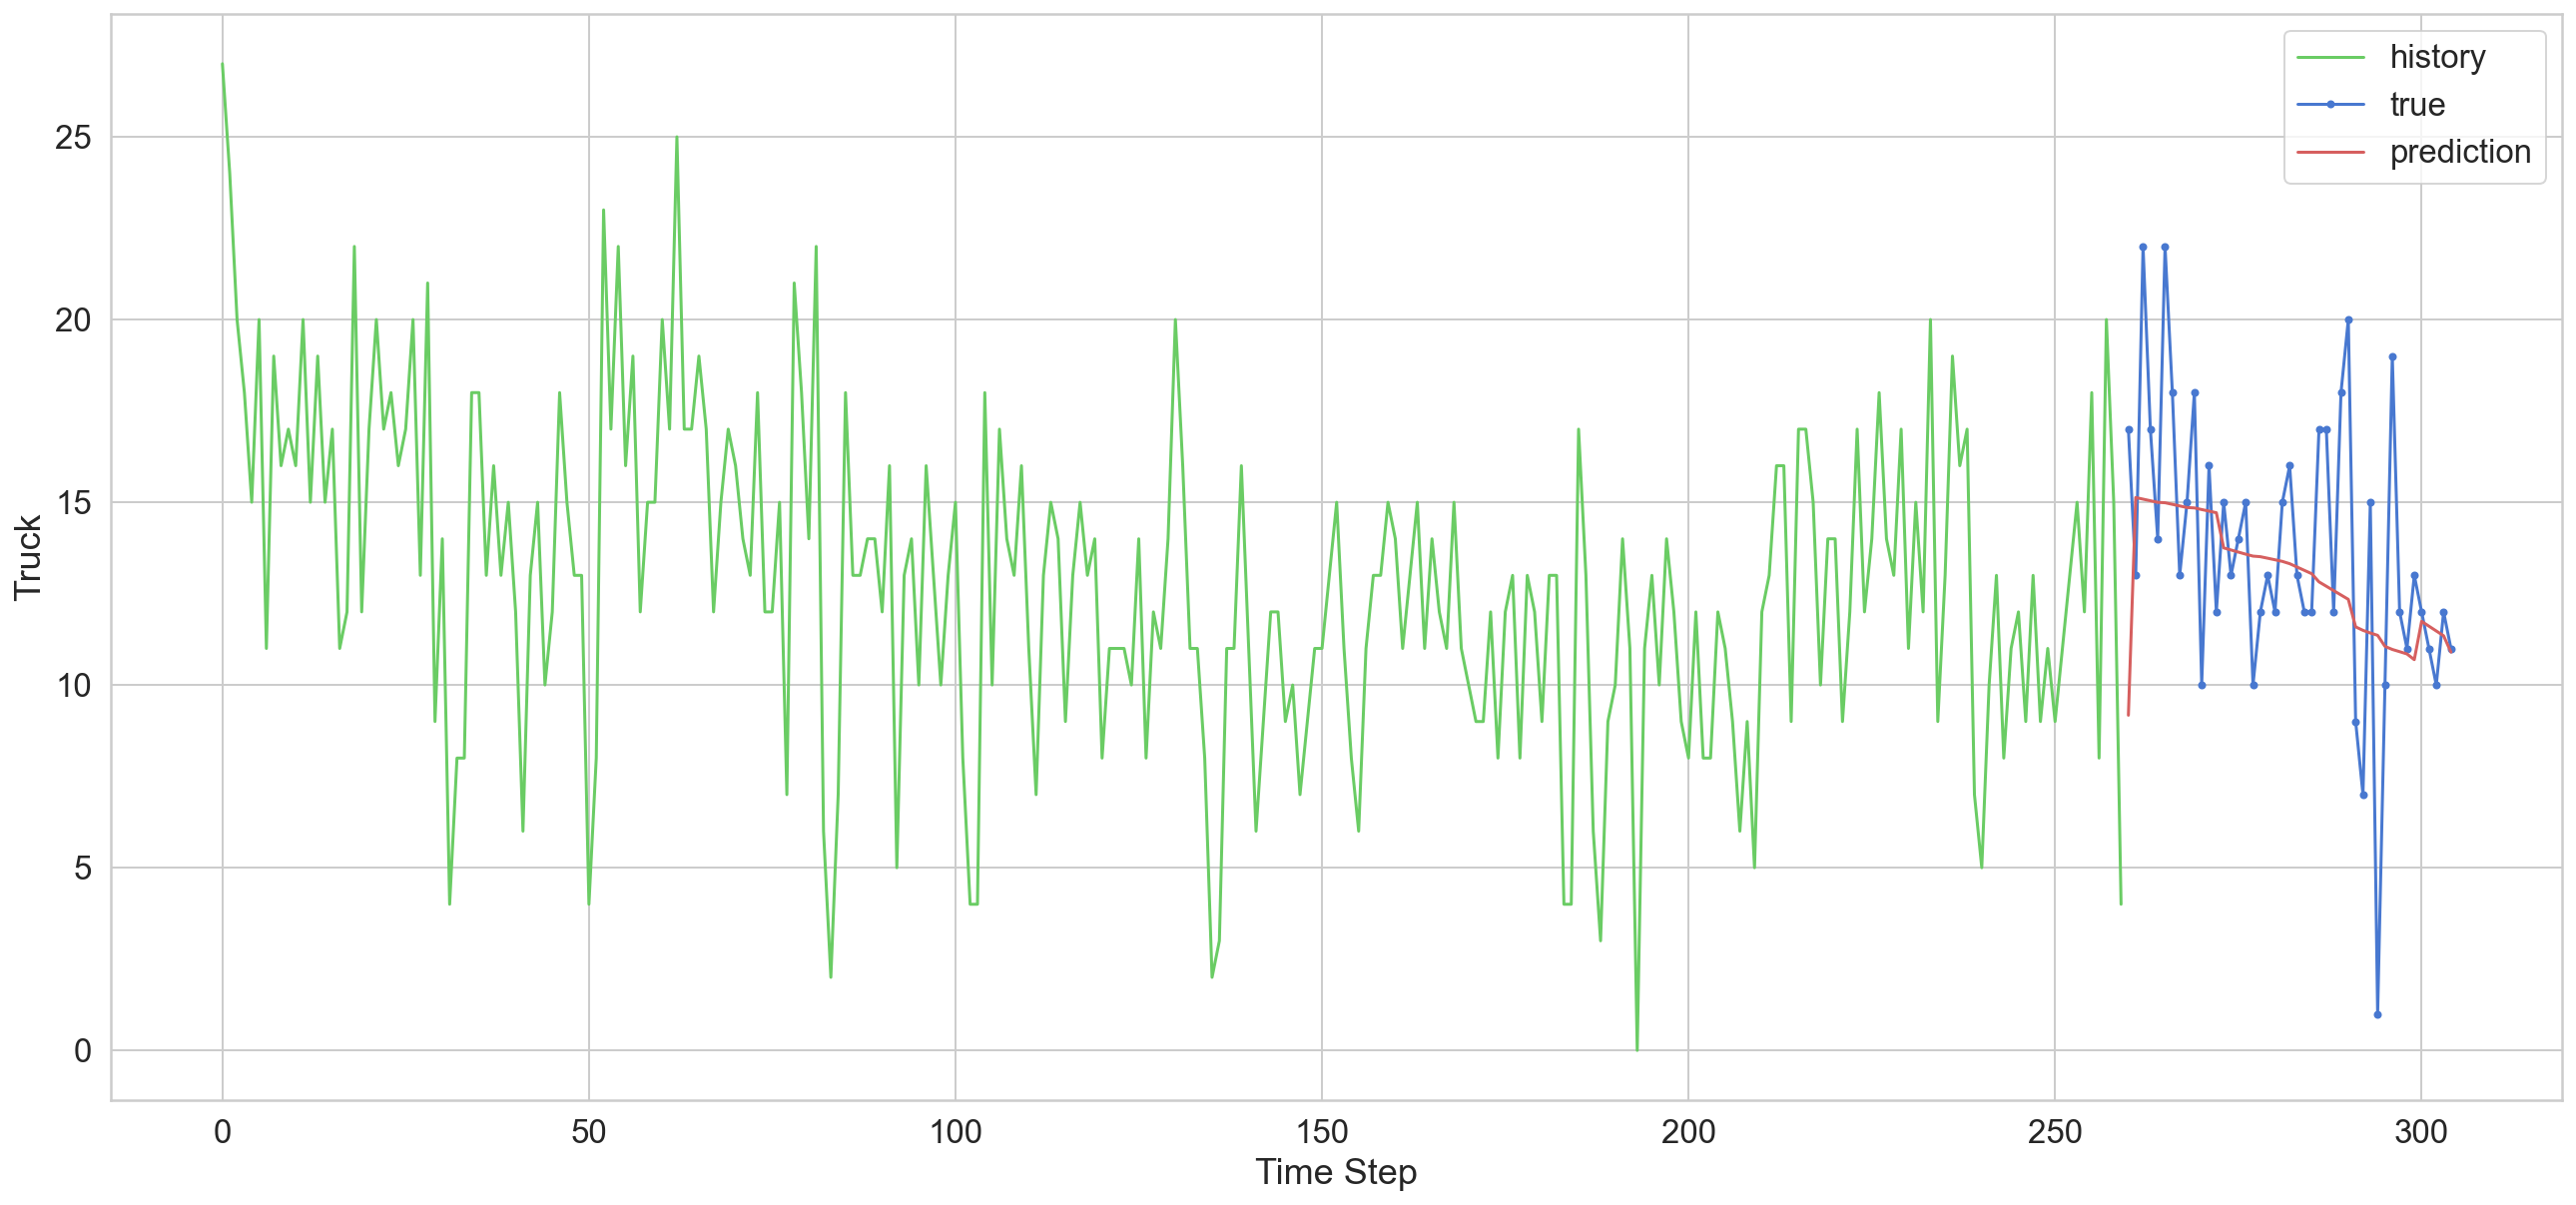

In [35]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, 'r', label="prediction")
plt.ylabel('Truck')
plt.xlabel('Time Step')
plt.legend()
plt.show();